In [1]:
import os
import torch
import random
import pandas as pd
import numpy as np
import pickle
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
import torch.nn.functional as F

from utils.features import extract_temporal_features
from models.classical_models import train_and_compare_classical_models
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

from utils.image_utils import load_base_images
from utils.interpolation import spatial_interpolate
from models.autoencoder import Autoencoder
from models.mse_model import MSEModel
from models.npp_model import NPPModel
from training.train_eval import train_model, evaluate_model
from datasets.cropped_sensor_dataset import CroppedSensorDataset
from datasets.multi_crop_sensor_dataset import MultiCropSensorDataset
from datasets.sensor_image_dataset import MultichannelSensorImageDataset
from datasets.auxiliar_dataset import *

In [3]:
# Config
DATA_FOLDER_1 = "./data/Pollution/Brookline"
DATA_FOLDER_2 = "./data/Pollution/Chelsea"  # Second data folder
LOOKBACK = 5
PIXELS_PER_DEGREE = 3000
CROP_SIZE = (64, 64)
EPOCHS = 30

# Load data from both folders
print(f"Loading data from {DATA_FOLDER_1}...")
data1 = load_dataset_from_folder(DATA_FOLDER_1, PIXELS_PER_DEGREE)
print(f"Loading data from {DATA_FOLDER_2}...")
data2 = load_dataset_from_folder(DATA_FOLDER_2, PIXELS_PER_DEGREE)

# Print grid dimensions for debugging
print(f"Grid dimensions for dataset 1: {data1['grid_dimensions']}")
print(f"Grid dimensions for dataset 2: {data2['grid_dimensions']}")

# Create raw datasets from both sources
print("Creating raw datasets...")
raw_dataset1 = MultichannelSensorImageDataset(
    data1['pm25'], data1['temps'], data1['rh'], 
    data1['elevation'], data1['sensor_pixel_map'], 
    data1['base_images_tensor'], lookback=LOOKBACK
)

raw_dataset2 = MultichannelSensorImageDataset(
    data2['pm25'], data2['temps'], data2['rh'], 
    data2['elevation'], data2['sensor_pixel_map'], 
    data2['base_images_tensor'], lookback=LOOKBACK
)

# Compute combined stats for normalization
combined_mean, combined_std = compute_combined_stats(raw_dataset1, raw_dataset2, max_samples=300)

# Create normalized datasets using combined stats
print("Creating normalized datasets...")
full_dataset1 = MultichannelSensorImageDataset(
    data1['pm25'], data1['temps'], data1['rh'], 
    data1['elevation'], data1['sensor_pixel_map'], 
    data1['base_images_tensor'], lookback=LOOKBACK, 
    normalize=True, stats=(combined_mean, combined_std)
)

full_dataset2 = MultichannelSensorImageDataset(
    data2['pm25'], data2['temps'], data2['rh'], 
    data2['elevation'], data2['sensor_pixel_map'], 
    data2['base_images_tensor'], lookback=LOOKBACK, 
    normalize=True, stats=(combined_mean, combined_std)
)

# Split datasets chronologically
print("Splitting datasets...")
train_base1, val_base1, test_base1 = split_dataset(full_dataset1)
train_base2, val_base2, test_base2 = split_dataset(full_dataset2)

print(f"Dataset 1 - Train: {len(train_base1)}, Val: {len(val_base1)}, Test: {len(test_base1)}")
print(f"Dataset 2 - Train: {len(train_base2)}, Val: {len(val_base2)}, Test: {len(test_base2)}")

# Initialize multi-crop datasets directly from the base datasets (no resizing needed)
print("Creating multi-crop datasets...")

# Training set from both datasets
train_dataset = MultiCropSensorDataset(
    base_datasets=[train_base1, train_base2],
    num_crops_per_dataset=4,  # 4 crops per sample from each dataset
    crop_size=CROP_SIZE,
    max_attempts=30
)

# Validation set from both datasets
val_dataset = MultiCropSensorDataset(
    base_datasets=[val_base1, val_base2],
    num_crops_per_dataset=4,
    crop_size=CROP_SIZE,
    max_attempts=30
)

# Test set from both datasets
test_dataset = MultiCropSensorDataset(
    base_datasets=[test_base1, test_base2],
    num_crops_per_dataset=4,
    crop_size=CROP_SIZE,
    max_attempts=30
)

print(f"Combined Multi-crop - Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=1, collate_fn=custom_collate_fn)

# Models
input_channels = LOOKBACK + 3 + data1['base_images_tensor'].shape[0]
input_shape = CROP_SIZE
auto_mse = Autoencoder([32, 64], [32], input_shape, input_channels, param_size=0)
auto_npp = Autoencoder([32, 64], [32], input_shape, input_channels, param_size=1)
mse_model = MSEModel(auto_mse)
npp_model = NPPModel(auto_npp, kernel_mode="predicted")

Loading data from ./data/Pollution/Brookline...
Loading data from ./data/Pollution/Chelsea...
Grid dimensions for dataset 1: (115, 163)
Grid dimensions for dataset 2: (73, 119)
Creating raw datasets...
Creating normalized datasets...
Splitting datasets...
Dataset 1 - Train: 1995, Val: 427, Test: 429
Dataset 2 - Train: 1155, Val: 247, Test: 249
Creating multi-crop datasets...
Combined Multi-crop - Train: 12600, Val: 2696, Test: 2712


In [4]:
# Step 1: Run the checks on your raw datasets
check_and_fix_dataset(raw_dataset1, num_samples=50)
check_and_fix_dataset(raw_dataset2, num_samples=50)

# Step 2: Check your combined datasets
check_and_fix_dataset(train_dataset, num_samples=100, fix_nans=False)
check_and_fix_dataset(val_dataset, num_samples=50, fix_nans=False)
check_and_fix_dataset(test_dataset, num_samples=50, fix_nans=False)

# Step 3: Validate your data loaders
validate_loaders(train_loader, val_loader, test_loader)

Checking 50 samples for NaN/Inf values...
No NaN/Inf values found. Dataset is clean!
Checking 50 samples for NaN/Inf values...
No NaN/Inf values found. Dataset is clean!
Checking 100 samples for NaN/Inf values...
No NaN/Inf values found. Dataset is clean!
Checking 50 samples for NaN/Inf values...
No NaN/Inf values found. Dataset is clean!
Checking 50 samples for NaN/Inf values...
No NaN/Inf values found. Dataset is clean!
Validating data loaders for NaN/Inf values...
Checking training loader...
Checking validation loader...
Checking test loader...
All data loaders are clean!


True

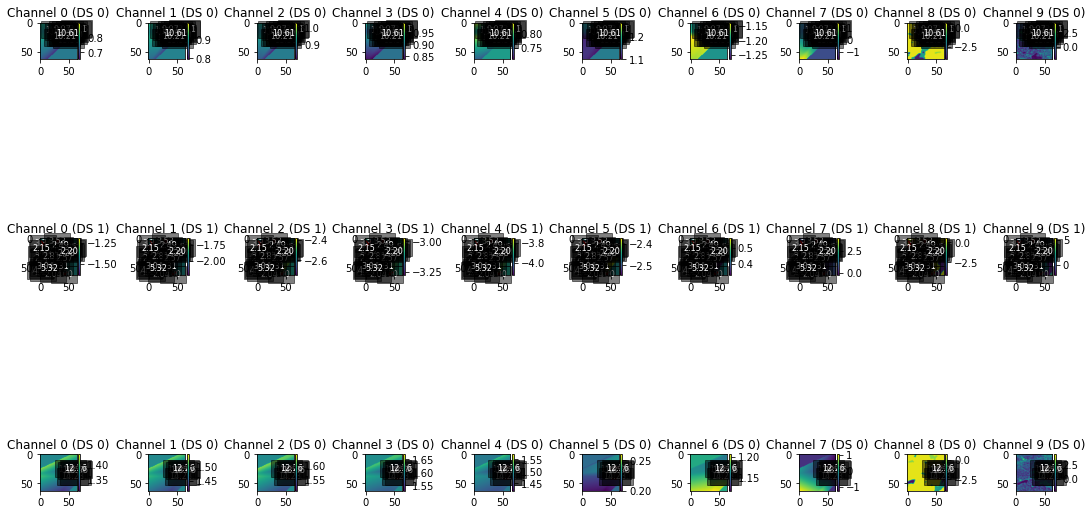

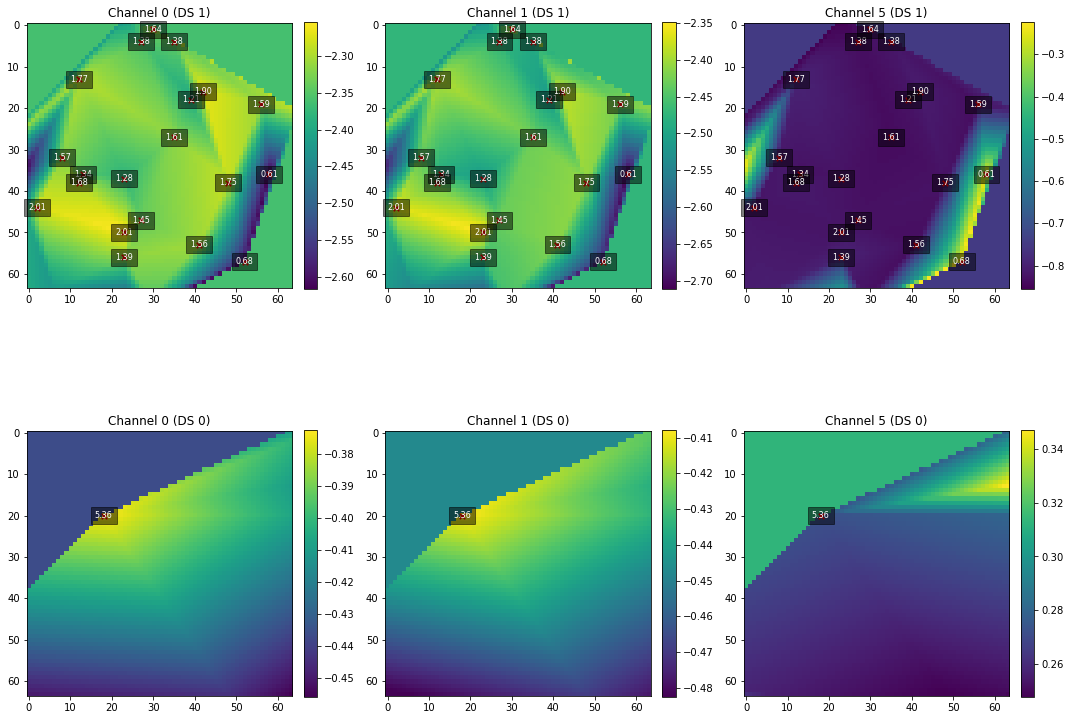

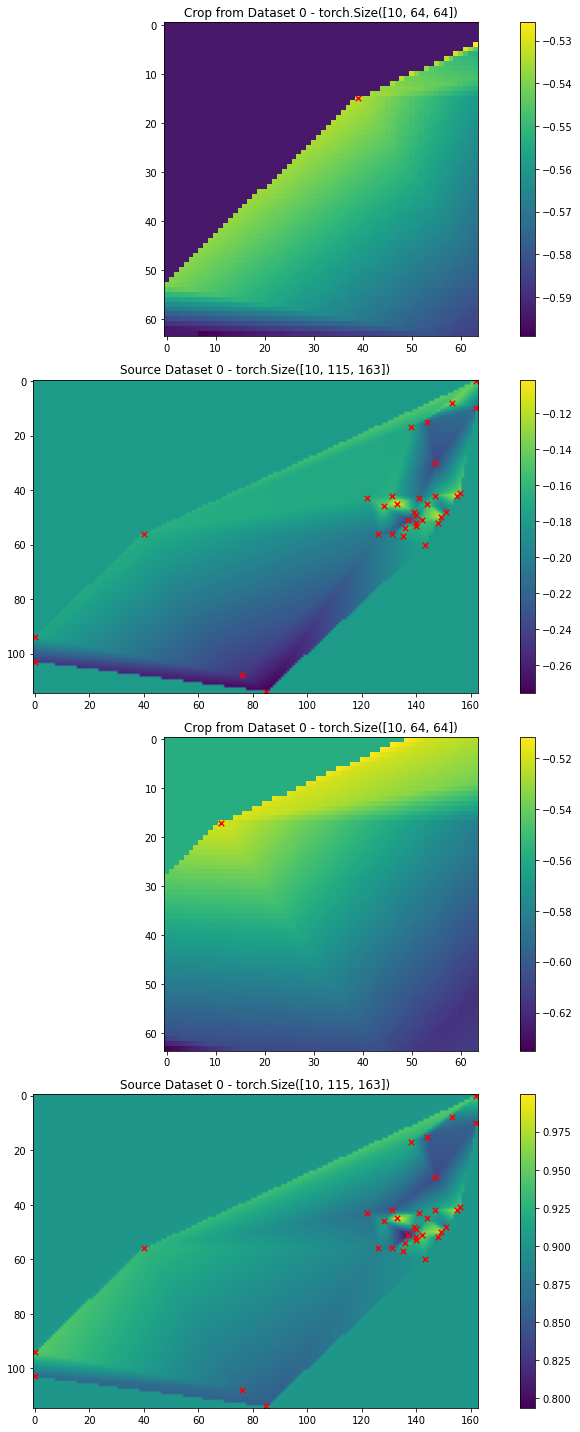

Dataset length: 12600

Sample structure:

Sample 1:
  image: Tensor shape torch.Size([10, 64, 64]), dtype torch.float32
    Value range: [-2.047, 5.250]
  pins: Tensor shape torch.Size([44, 2]), dtype torch.int64
    Value range: [0.000, 63.000]
  outputs: Tensor shape torch.Size([44]), dtype torch.float32
    Value range: [1.054, 5.884]
  dataset_idx: <class 'int'> - 1
  Number of pins: 44
  Pin coordinates range: x [0.0, 59.0], y [1.0, 63.0]
  Output values range: [1.054, 5.884]

Sample 2:
  image: Tensor shape torch.Size([10, 64, 64]), dtype torch.float32
    Value range: [-4.067, 5.250]
  pins: Tensor shape torch.Size([29, 2]), dtype torch.int64
    Value range: [0.000, 60.000]
  outputs: Tensor shape torch.Size([29]), dtype torch.float32
    Value range: [1.987, 6.728]
  dataset_idx: <class 'int'> - 1
  Number of pins: 29
  Pin coordinates range: x [0.0, 59.0], y [7.0, 60.0]
  Output values range: [1.987, 6.728]
Multi-dataset distribution from 100 samples:
------------------------

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import torch

def visualize_dataset_samples(dataset, num_samples=3, figsize=(15, 12), channels_to_show=None, show_pins=True, save_path=None):
    """
    Visualize random samples from a dataset to verify data is being processed correctly.
    
    Args:
        dataset: The dataset to sample from
        num_samples: Number of samples to visualize
        figsize: Figure size (width, height) in inches
        channels_to_show: List of channel indices to visualize (None for all)
        show_pins: Whether to overlay sensor pins on the images
        save_path: Path to save the visualization (None to display instead)
    """
    # Select random samples
    indices = np.random.choice(range(len(dataset)), min(num_samples, len(dataset)), replace=False)
    
    # Get sample data
    samples = [dataset[idx] for idx in indices]
    
    # Determine which channels to show
    if channels_to_show is None:
        # Show all channels
        channels_to_show = list(range(samples[0]['image'].shape[0]))
    
    # Calculate grid dimensions
    total_channels = len(channels_to_show)
    rows = num_samples
    cols = total_channels
    
    # Create figure
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if rows == 1 and cols == 1:
        axes = np.array([[axes]])
    elif rows == 1:
        axes = axes.reshape(1, -1)
    elif cols == 1:
        axes = axes.reshape(-1, 1)
    
    # Display each sample and its channels
    for i, sample in enumerate(samples):
        image = sample['image']
        pins = sample['pins']
        outputs = sample['outputs']
        # Get dataset index if available (new in the multi-dataset version)
        dataset_idx = sample.get('dataset_idx', None)
        
        # For each channel
        for j, channel_idx in enumerate(channels_to_show):
            # Get current axis
            ax = axes[i, j]
            
            # Get channel data
            channel_data = image[channel_idx].cpu().numpy()
            
            # Create normalized colormap for better visualization
            norm = Normalize(vmin=channel_data.min(), vmax=channel_data.max())
            
            # Plot channel as image
            img = ax.imshow(channel_data, cmap='viridis', norm=norm)
            plt.colorbar(img, ax=ax, fraction=0.046, pad=0.04)
            
            # Add pins if requested
            if show_pins and pins is not None and len(pins) > 0:
                # Convert pins to numpy for plotting
                pin_coords = pins.cpu().numpy()
                ax.scatter(pin_coords[:, 1], pin_coords[:, 0], c='red', s=30, marker='x')
                
                # Annotate each pin with its value if outputs are available
                if outputs is not None:
                    output_values = outputs.cpu().numpy()
                    for pin_idx, (y, x) in enumerate(pin_coords):
                        value = output_values[pin_idx]
                        ax.text(x, y, f'{value:.2f}', color='white', fontsize=8,
                                ha='center', va='center', bbox=dict(facecolor='black', alpha=0.5))
            
            # Set title for this channel, including dataset info if available
            title = f"Channel {channel_idx}"
            if dataset_idx is not None:
                title += f" (DS {dataset_idx})"
            ax.set_title(title)
            
    plt.tight_layout()
    
    # Save or show
    if save_path:
        plt.savefig(save_path)
        print(f"Visualization saved to {save_path}")
    else:
        plt.show()
    
    return fig

def visualize_multi_dataset_crops(multicrop_dataset, source_datasets, num_samples=2, figsize=(15, 20), channel_idx=0):
    """
    Compare cropped samples with their source datasets to verify cropping is working correctly.
    
    Args:
        multicrop_dataset: The MultiCropSensorDataset containing crops
        source_datasets: List of original datasets
        num_samples: Number of samples to visualize from each dataset
        figsize: Figure size (width, height) in inches
        channel_idx: Which channel to show
    """
    # Get some random samples from the multicrop dataset
    crop_indices = np.random.choice(range(len(multicrop_dataset)), 
                                    min(num_samples * len(source_datasets), len(multicrop_dataset)), 
                                    replace=False)
    crop_samples = [multicrop_dataset[idx] for idx in crop_indices]
    
    # Group samples by source dataset
    crops_by_dataset = {}
    for sample in crop_samples:
        dataset_idx = sample.get('dataset_idx', 0)
        if dataset_idx not in crops_by_dataset:
            crops_by_dataset[dataset_idx] = []
        if len(crops_by_dataset[dataset_idx]) < num_samples:
            crops_by_dataset[dataset_idx].append(sample)
    
    # Calculate total rows needed (one for each crop and one for its source)
    total_rows = sum(len(samples) * 2 for samples in crops_by_dataset.values())
    
    # Create figure
    fig, axes = plt.subplots(total_rows, 1, figsize=figsize)
    if total_rows == 1:
        axes = [axes]  # Make it iterable
    
    # Track current row
    current_row = 0
    
    # Plot each dataset's crops
    for dataset_idx, crop_samples in crops_by_dataset.items():
        for crop in crop_samples:
            # Determine info about this crop
            # Note: these are already looked up in the multicrop __getitem__ method,
            # but we need them here to find the original sample
            dataset_idx = crop.get('dataset_idx', 0)
            
            # For MultiCropSensorDataset, we need to find the original sample
            # This is tricky since we don't have the base_idx and crop position stored
            # Let's use a heuristic to find a matching sample from the source dataset
            
            # First plot the crop
            ax_crop = axes[current_row]
            crop_img = crop['image']
            crop_pins = crop['pins']
            crop_channel = crop_img[channel_idx].cpu().numpy()
            
            norm = Normalize(vmin=crop_channel.min(), vmax=crop_channel.max())
            img = ax_crop.imshow(crop_channel, cmap='viridis', norm=norm)
            plt.colorbar(img, ax=ax_crop, fraction=0.046, pad=0.04)
            
            if crop_pins is not None and len(crop_pins) > 0:
                pin_coords = crop_pins.cpu().numpy()
                ax_crop.scatter(pin_coords[:, 1], pin_coords[:, 0], c='red', s=30, marker='x')
            
            ax_crop.set_title(f"Crop from Dataset {dataset_idx} - {crop_img.shape}")
            current_row += 1
            
            # Now show a sample from the source dataset
            # Just pick a random sample from the source as an example
            source_dataset = source_datasets[dataset_idx]
            source_idx = np.random.choice(range(len(source_dataset)))
            source_sample = source_dataset[source_idx]
            
            ax_source = axes[current_row]
            source_img = source_sample['image']
            source_pins = source_sample['pins']
            source_channel = source_img[channel_idx].cpu().numpy()
            
            norm = Normalize(vmin=source_channel.min(), vmax=source_channel.max())
            img = ax_source.imshow(source_channel, cmap='viridis', norm=norm)
            plt.colorbar(img, ax=ax_source, fraction=0.046, pad=0.04)
            
            if source_pins is not None and len(source_pins) > 0:
                pin_coords = source_pins.cpu().numpy()
                ax_source.scatter(pin_coords[:, 1], pin_coords[:, 0], c='red', s=30, marker='x')
            
            ax_source.set_title(f"Source Dataset {dataset_idx} - {source_img.shape}")
            current_row += 1
    
    plt.tight_layout()
    plt.show()
    
    return fig

def check_dataset_structure(dataset, num_samples=5):
    """
    Check the structure of samples in a dataset and print diagnostic information.
    
    Args:
        dataset: The dataset to check
        num_samples: Number of samples to examine
    """
    indices = np.random.choice(range(len(dataset)), min(num_samples, len(dataset)), replace=False)
    
    print(f"Dataset length: {len(dataset)}")
    print("\nSample structure:")
    
    for i, idx in enumerate(indices):
        sample = dataset[idx]
        print(f"\nSample {i+1}:")
        
        for key, value in sample.items():
            if isinstance(value, torch.Tensor):
                print(f"  {key}: Tensor shape {value.shape}, dtype {value.dtype}")
                try:
                    print(f"    Value range: [{value.min().item():.3f}, {value.max().item():.3f}]")
                except:
                    print(f"    Empty tensor or contains NaN values")
            else:
                print(f"  {key}: {type(value)} - {value}")
        
        if 'pins' in sample and 'outputs' in sample:
            print(f"  Number of pins: {len(sample['pins'])}")
            if len(sample['pins']) > 0:
                print(f"  Pin coordinates range: x [{sample['pins'][:, 1].min().item():.1f}, {sample['pins'][:, 1].max().item():.1f}], "
                      f"y [{sample['pins'][:, 0].min().item():.1f}, {sample['pins'][:, 0].max().item():.1f}]")
                print(f"  Output values range: [{sample['outputs'].min().item():.3f}, {sample['outputs'].max().item():.3f}]")
    
    return True

def check_multi_dataset_distribution(multicrop_dataset, num_samples=100):
    """
    Check the distribution of samples across source datasets.
    
    Args:
        multicrop_dataset: MultiCropSensorDataset to analyze
        num_samples: Number of samples to check
    """
    indices = np.random.choice(range(len(multicrop_dataset)), min(num_samples, len(multicrop_dataset)), replace=False)
    
    # Count samples from each dataset
    dataset_counts = {}
    pins_per_dataset = {}
    
    for idx in indices:
        sample = multicrop_dataset[idx]
        dataset_idx = sample.get('dataset_idx', 0)
        
        # Count this sample
        if dataset_idx not in dataset_counts:
            dataset_counts[dataset_idx] = 0
            pins_per_dataset[dataset_idx] = []
        
        dataset_counts[dataset_idx] += 1
        pins_per_dataset[dataset_idx].append(len(sample['pins']))
    
    # Print statistics
    print(f"Multi-dataset distribution from {num_samples} samples:")
    print("--------------------------------------------------------")
    for dataset_idx, count in dataset_counts.items():
        print(f"Dataset {dataset_idx}:")
        print(f"  Samples: {count} ({count/num_samples*100:.1f}%)")
        if pins_per_dataset[dataset_idx]:
            avg_pins = np.mean(pins_per_dataset[dataset_idx])
            print(f"  Average pins per crop: {avg_pins:.1f}")
    print("--------------------------------------------------------")

# Example usage:
# Now using our visualization functions with the new multi-dataset structure

# Example 1: Visualize samples from the multi-crop dataset
visualize_dataset_samples(
    dataset=train_dataset,
    num_samples=3,
    figsize=(15, 10)
)

# Example 2: Visualize specific channels
visualize_dataset_samples(
    dataset=train_dataset,
    num_samples=2,
    channels_to_show=[0, 1, 5],  # First two history channels and a static channel
    show_pins=True
)

# Example 3: Compare crops with source datasets
visualize_multi_dataset_crops(
    multicrop_dataset=train_dataset,
    source_datasets=[train_base1, train_base2],
    num_samples=2
)

# Example 4: Check dataset structure
check_dataset_structure(
    dataset=train_dataset,
    num_samples=2
)

# Example 5: Check distribution of samples across source datasets
check_multi_dataset_distribution(
    multicrop_dataset=train_dataset,
    num_samples=100
)

[MSE] Epoch 1/10 | Train Loss: 23.3886
[MSE]  └── Val MSE: 13.0617 | R²: 0.5199


[MSE] Epoch 2/10 | Train Loss: 6.9672
[MSE]  └── Val MSE: 12.1968 | R²: 0.5517


[MSE] Epoch 3/10 | Train Loss: 5.9074
[MSE]  └── Val MSE: 11.3939 | R²: 0.5812


[MSE] Epoch 4/10 | Train Loss: 5.3070
[MSE]  └── Val MSE: 10.6269 | R²: 0.6094


[MSE] Epoch 5/10 | Train Loss: 4.8847
[MSE]  └── Val MSE: 9.9972 | R²: 0.6325


[MSE] Epoch 6/10 | Train Loss: 4.6247
[MSE]  └── Val MSE: 9.7132 | R²: 0.6430


[MSE] Epoch 7/10 | Train Loss: 4.4259
[MSE]  └── Val MSE: 9.5394 | R²: 0.6494


[MSE] Epoch 8/10 | Train Loss: 4.2893
[MSE]  └── Val MSE: 9.3427 | R²: 0.6566


[MSE] Epoch 9/10 | Train Loss: 4.1788
[MSE]  └── Val MSE: 9.2005 | R²: 0.6618


[MSE] Epoch 10/10 | Train Loss: 4.0728
[MSE]  └── Val MSE: 9.0297 | R²: 0.6681
[MSE] Restored best model (Val MSE: 9.0297)


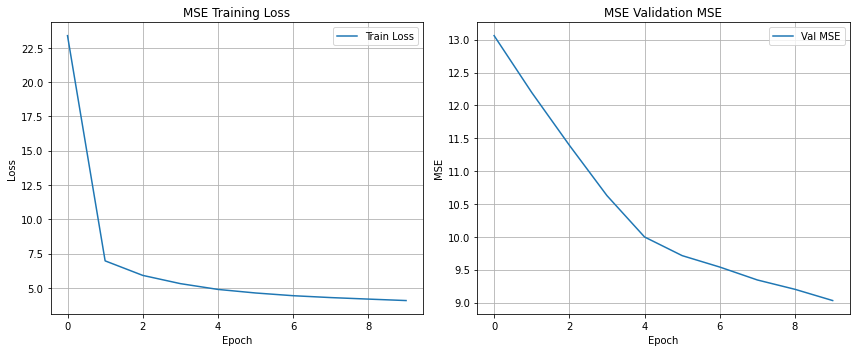

[MSE] Test MSE: 5.7996 | R²: 0.7876


[NPP] Epoch 1/10 | Train Loss: 497.3540
[NPP]  └── Val MSE: 13.8603 | R²: 0.4905


[NPP] Epoch 2/10 | Train Loss: 176.7487
[NPP]  └── Val MSE: 12.4921 | R²: 0.5408


[NPP] Epoch 3/10 | Train Loss: 152.9214
[NPP]  └── Val MSE: 11.4374 | R²: 0.5796


[NPP] Epoch 4/10 | Train Loss: 135.2926
[NPP]  └── Val MSE: 10.6439 | R²: 0.6088


[NPP] Epoch 5/10 | Train Loss: 123.2619
[NPP]  └── Val MSE: 10.0093 | R²: 0.6321


[NPP] Epoch 6/10 | Train Loss: 115.7981
[NPP]  └── Val MSE: 9.6859 | R²: 0.6440


[NPP] Epoch 7/10 | Train Loss: 111.4799
[NPP]  └── Val MSE: 9.2643 | R²: 0.6595


[NPP] Epoch 8/10 | Train Loss: 106.9656
[NPP]  └── Val MSE: 9.4154 | R²: 0.6539


[NPP] Epoch 9/10 | Train Loss: 103.3586
[NPP]  └── Val MSE: 8.8753 | R²: 0.6738


[NPP] Epoch 10/10 | Train Loss: 101.7784
[NPP]  └── Val MSE: 8.7185 | R²: 0.6795
[NPP] Restored best model (Val MSE: 8.7185)


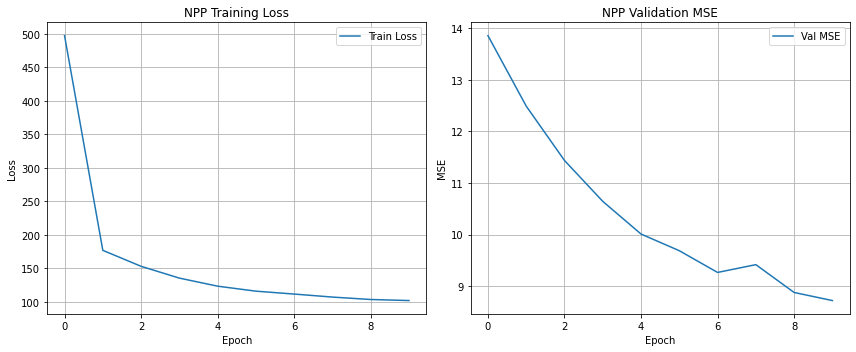

[NPP] Test MSE: 5.3294 | R²: 0.8048


In [7]:
# Train and evaluate
mse_model = train_model(mse_model, train_loader, val_loader, test_loader, name="MSE", device='cpu', epochs=EPOCHS)
npp_model = train_model(npp_model, train_loader, val_loader, test_loader, name="NPP", device='cpu', epochs=EPOCHS)

In [3]:
# Extract features
X_train, y_train = extract_temporal_features(train_dataset, temporal_channels=LOOKBACK+1)
X_test, y_test = extract_temporal_features(test_dataset, temporal_channels=LOOKBACK+1)

# Train classical regressors
#classical_results = train_and_compare_classical_models(X_train, y_train, X_test, y_test)

Extracting features: 100%|██████████| 3432/3432 [00:38<00:00, 89.18it/s]


In [ ]:
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

models = {
    "KNN": KNeighborsRegressor(),
    "SVR": SVR(),
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results[name] = {
        "model": model,
        "y_pred": y_pred,
        "mse": mse,
        "r2": r2
    }

    print(f"[{name}] MSE: {mse:.4f} | R²: {r2:.4f}")


[KNN] MSE: 8.7160 | R²: 0.7393


In [ ]:
mse_mse, mse_r2 = evaluate_model(mse_model, test_loader, name="MSE", device='cpu')
npp_mse, npp_r2 = evaluate_model(npp_model, test_loader, name="NPP", device='cpu')

# Gather results
model_names = ["MSE", "NPP"] + list(classical_results.keys())
mses = [mse_mse, npp_mse] + [classical_results[k]["mse"] for k in classical_results]
r2s = [mse_r2, npp_r2] + [classical_results[k]["r2"] for k in classical_results]

# Plot comparison
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(model_names, mses, color='skyblue')
plt.title("Test MSE Comparison")
plt.ylabel("Mean Squared Error")
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.bar(model_names, r2s, color='lightgreen')
plt.title("Test R² Comparison")
plt.ylabel("R² Score")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()